# Preliminaries

In [3]:
# numpy and pandas imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML Libraries for scikit
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn import tree
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,\
                            precision_recall_curve,precision_score,recall_score,roc_auc_score,roc_curve,\
                            matthews_corrcoef, f1_score, make_scorer, auc
from scipy.stats import skew

#  Recursive Feature Elimination
from sklearn.feature_selection import RFE
        
# Python imports
from math import log, sqrt
import re
import collections
import warnings

# decision tree visualization related imports
import pydotplus
import graphviz

from IPython.display import Image

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 400

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Loading Data set

In [5]:
df_original = pd.read_excel('default of credit card clients.xls',sheetname='Data',header=1,index_col='ID')

In [6]:
df = df_original.copy()

## About DataSet and Some dataset column naming standardizations
+ Column naming standardization (Replacing pay_0 with pay_1 to make it standard with other columns)
+ lower case names for columns (referring to them using column name would make it easy)
+ Dataset - domain information and data type information, interpretations

We lowercase the column name, and rename the column names when required, In particular, remarkably this dataset misses a colum  PAY_1. In the analysis here below we assume that PAY_0 is actually pay_1, to be consider the repayment of the month prior to the month where we calculate the defaulting (which is October 2005, in this particular dataset)

In [7]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(columns={"pay_0": "pay_1","default payment next month":"default_pay"})
cols = df.columns.values
col_names = [str(s) for s in cols]
# col_names

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
limit_bal      30000 non-null int64
sex            30000 non-null int64
education      30000 non-null int64
marriage       30000 non-null int64
age            30000 non-null int64
pay_1          30000 non-null int64
pay_2          30000 non-null int64
pay_3          30000 non-null int64
pay_4          30000 non-null int64
pay_5          30000 non-null int64
pay_6          30000 non-null int64
bill_amt1      30000 non-null int64
bill_amt2      30000 non-null int64
bill_amt3      30000 non-null int64
bill_amt4      30000 non-null int64
bill_amt5      30000 non-null int64
bill_amt6      30000 non-null int64
pay_amt1       30000 non-null int64
pay_amt2       30000 non-null int64
pay_amt3       30000 non-null int64
pay_amt4       30000 non-null int64
pay_amt5       30000 non-null int64
pay_amt6       30000 non-null int64
default_pay    30000 non-null int64
dtypes: int64(24)
memory us

<span style="color:black; font-family: 'calibri'; font-size: 1.2em;">As you can see from the above information, the dataset does not look to have missing values.</b>

In [9]:
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['default_pay'] = df['default_pay'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'default_pay'))

Explanatory variables:  23
Number of Observations: 30000
Target variable:       'default payment next month' -> 'default_pay'


### DataSet description
<span style="color:black; font-family: 'calibri'; font-size: 1.2em;">This study leverages following 
+ <b>Dependent Variable</b>  : default payment (Yes = 1, No = 0), as the response variable
+ <b>Independent Variable</b>: 23 variables as explanatory variables and they are numeric. These are as follows : 
    
```
   ----------------------------------------------------------------------------------------------------------------------
   Name                   Numeric / Categorical          Explantion        
   ----------------------------------------------------------------------------------------------------------------------
   limit_bal              Numeric                        Amount of the given credit (NT dollar): 
                                                         it includes both the individual consumer credit 
                                                         and his/her family (supplementary) credit.
   
   sex                    Categorical                    Gender 
                                                         (1 = male; 2 = female)
   
   education              Categorical                  Education
                                                       (1 = graduate school; 2 = university; 3 = high school; 4 = others)
   
   marriage               Categorical                    Marital status 
                                                         (1 = married; 2 = single; 3 = others)
   
   age                    Numeric                        Age (years)
   
   pay_0 - pay_6          Numeric                        History of past payment. Past monthly payment records 
                                                         From April to September, 2005 as follows:
                        
                                                         pay_0 = the repayment status in September, 2005
                                                         pay_2 = the repayment status in August, 2005
                                                         ...
                                                         pay_6 = the repayment status in April, 2005 
                        
                                                         The measurement scale for the repayment status is: 
                                                         -1 = pay duly; 
                                                         1 = payment delay for one month 
                                                         2 = payment delay for two months
                                                         ...
                                                         8 = payment delay for eight months 
                                                         9 = payment delay for nine months and above
                        
   bill_amt1-bill_amt5    Numeric                        Amount of bill statement (NT dollar). 
                                                         bill_amt1 = amount of bill statement in September, 2005 
                                                         bill_amt2 = amount of bill statement in August, 2005
                                                         ...
                                                         bill_amt6= amount of bill statement in April, 2005 
                        
   pay_amt1-pay_amt6      Numeric                        Amount of previous payment (NT dollar)
                                                         pay_amt1 = amount paid in September, 2005
                                                         pay_amt2 = amount paid in August, 2005
                                                         ...
                                                         pay_amt6 = amount paid in April, 2005 
   ----------------------------------------------------------------------------------------------------------------------
```
</span>

In [10]:
df.head(5)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_pay
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


***

## Some initializations and reusable methods block

Collect all the mertics at one place for all the models used during training. This will help in comarison of these metrics.

In [11]:
# commonly used variables
pay_status_columns = []
for x in range(1,7): pay_status_columns.append("pay_"+ str(x))
    
bill_amt_columns = []
for x in range(1,7): bill_amt_columns.append("bill_amt"+ str(x))
    
pay_amt_columns = []
for x in range(1,7): pay_amt_columns.append("pay_amt"+ str(x))


# initialization block for ML
perf_metrics = ['Model','Model_Desc','TP','FP','FN','TN','AUC',\
                'Accuracy_Score','Precision','Recall',\
                'F1_Score', 'Matt_Coeff']
df_all_models = pd.DataFrame(columns=perf_metrics)
perf_metric_per_model = {}

In [57]:
# This is only required during model building exercise
# for model evaluation
# Get the performance metrics for the models
def save_performance_metrics(model, model_name, model_dsc, X_test, y_test, X_train=None, y_train=None):
    # nested inner method for adding performance metric
    def add_perf_metric_to_compare(perf_metric_per_model):
        global df_all_models
        model_name = perf_metric_per_model['Model']
        # if model data already exists then drop those rows
        if df_all_models[df_all_models['Model'] == model_name].shape[0] >= 1:
            ind = df_all_models[df_all_models['Model']== model_name].index
            df_all_models.drop(ind, inplace=True)
        s1 = pd.Series(perf_metric_per_model, perf_metric_per_model.keys())
        df_all_models = df_all_models.append(s1, ignore_index=True)    
    
    perf_metric_per_model = {}
#     print "Evaluating performance for {} description is {}"\
#                                         .format(model_name,model_description)
    perf_metric_per_model['Model'] = model_name
    perf_metric_per_model['Model_Desc'] = model_dsc
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    tn, fp, fn, tp = conf_mat.ravel()
    perf_metric_per_model['TP'], perf_metric_per_model['FP'] = tp, fp
    perf_metric_per_model['FN'], perf_metric_per_model['TN'] = fn, tn
    perf_metric_per_model['AP'], perf_metric_per_model['AN'] = tp+fn, fp+tn
    perf_metric_per_model['AUC'] = roc_auc_score(y_test, y_pred)
    perf_metric_per_model['F1_Score'] = f1_score(y_test, y_pred)
    perf_metric_per_model['Accuracy_Score'] = accuracy_score(y_test, y_pred)
    perf_metric_per_model['Precision'] = precision_score(y_test, y_pred)
    perf_metric_per_model['Recall'] = recall_score(y_test, y_pred) 
    perf_metric_per_model['Train_score'] = model.score(X_train, y_train)    
    perf_metric_per_model['Test_score'] = model.score(X_test, y_test)    
    perf_metric_per_model['Matt_Coeff'] = matthews_corrcoef(y_test, y_pred)
    s2 = pd.Series(perf_metric_per_model, index=perf_metric_per_model.keys())
    df_metric = pd.DataFrame(data=[s2], columns=perf_metrics)
    add_perf_metric_to_compare(perf_metric_per_model)
    return df_metric
    
# plot feature importances
# not applicable to Logistic Regression
def plot_feature_importance(model_name, importances, columns):
    # feature importances
    plt.figure(figsize=(12,6))
    indices = np.argsort(importances)[::-1]
    indices = indices[:10]
    plt.title('Top 10 Feature Importances by {}'.format(model_name))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), columns[indices])
    plt.xlabel('Relative Importance')
    plt.show()

# plot ROC and Precision, Recall curve
def plot_roc_and_precision(model_name, model, X_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    # AUC under ROC Curve 
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title('Receiver Operating Characteristic for {}'.format(model_name))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('TPR (Recall or Sensitivity)')
    plt.xlabel('FPR (1-Specificity)')
    
    # precision and recall curve
    plt.subplot(122)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    plt.step(recall, precision, color='b', alpha=0.1,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve for {}'.format(model_name))
    
    plt.tight_layout(pad=4.0, w_pad=0.5, h_pad=1.0)    
    plt.show()

metrics = pd.DataFrame(index=['accuracy','precision','recall','auc_roc_score'],columns=['LogR','DTree','RF'])
# metrics    
def CMatrix(CM,labels=['pay','default']):
    df1 = pd.DataFrame(data=CM,index=labels,columns=labels)
    df1.index.name = 'Actual'
    df1.columns.name = 'Predicted'
    df1.loc['Total'] = df1.sum()
    df1['Total'] = df1.sum(axis=1)
    return df1

# EDA

## Information related to Credit Limit, Payment Status, Bill Amount and Bill Payment
We will look at how payment status, bill amount and bill payment columns look like.

Class Statistics on entire data 30000:


,Count,Percent Split
Not Default,23364,77.88
Default,6636,22.12


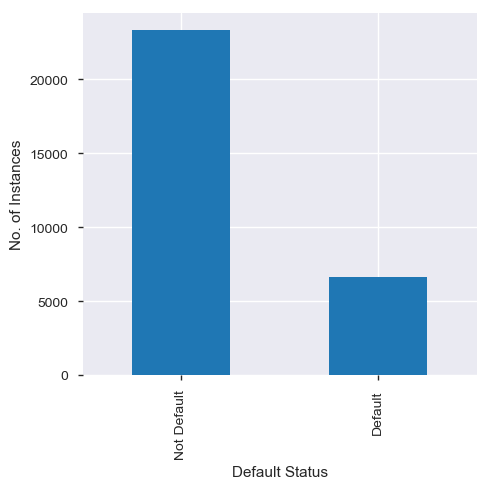

In [14]:
total_cnt = df.shape[0]
print 'Class Statistics on entire data {}:'.format(total_cnt)
cls_cnt = df['default_pay'].value_counts()
cls_stats = pd.DataFrame ({"Count": [cls_cnt[0], cls_cnt[1]],\
                        "Percent Split" : [((cls_cnt[0] * 100.0) /total_cnt), ((cls_cnt[1] * 100.0) /total_cnt)]},
                         index=["Not Default", "Default"])
display(cls_stats)
plt.figure(figsize=(5,5))
ax = cls_cnt.plot(kind='bar')
ax.set_xlabel("Default Status")
ax.set_ylabel("No. of Instances")
ax.set_xticklabels(['Not Default', 'Default'])
#     for p in ax.patches:
#         ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+300))
plt.tight_layout()
plt.show()

## Information related to Credit Limit, Payment Status, Bill Amount and Bill Payment
We will look at how payment status, bill amount and bill payment columns look like.

In [15]:
df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
ID,,,,,,
1,2,2,-1,-1,-2,-2
2,-1,2,0,0,0,2
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,-1,0,-1,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,-1,-1,0,0,-1
9,0,0,2,0,0,0


In [16]:
print 'Paid Amount Columns'
display(df[pay_amt_columns].head(10))
print ('==')*10
print '\nPaid Amount Columns Statistics'
display(df[pay_amt_columns].describe())

Paid Amount Columns


,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
ID,,,,,,
1,0,689,0,0,0,0
2,0,1000,1000,1000,0,2000
3,1518,1500,1000,1000,1000,5000
4,2000,2019,1200,1100,1069,1000
5,2000,36681,10000,9000,689,679
6,2500,1815,657,1000,1000,800
7,55000,40000,38000,20239,13750,13770
8,380,601,0,581,1687,1542
9,3329,0,432,1000,1000,1000



Paid Amount Columns Statistics


,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [17]:
print 'Bill Amount Columns'
display(df[bill_amt_columns].head(10))
print ('==')*10
print '\nBill Amount Columns Statistics'
display(df[bill_amt_columns].describe())

Bill Amount Columns


,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
ID,,,,,,
1,3913,3102,689,0,0,0
2,2682,1725,2682,3272,3455,3261
3,29239,14027,13559,14331,14948,15549
4,46990,48233,49291,28314,28959,29547
5,8617,5670,35835,20940,19146,19131
6,64400,57069,57608,19394,19619,20024
7,367965,412023,445007,542653,483003,473944
8,11876,380,601,221,-159,567
9,11285,14096,12108,12211,11793,3719



Bill Amount Columns Statistics


,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [18]:
df['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

In [19]:
df_t = df.copy()

In [20]:
df_pay = pd.DataFrame(columns=['credit_assigned', 'total_bill','average_bill', 'total_payment', \
                               'average_payment', 'amt_owed','amt_owed_more_thn_credit','default_status',
                              'adv_pay', 'min_pay', 'delay_pay'])
df_pay['credit_assigned'] = df['limit_bal']
df_pay['total_bill'] = df[bill_amt_columns].sum(axis=1)
df_pay['average_bill'] = df[bill_amt_columns].mean(axis=1)
df_pay['total_payment'] = df[pay_amt_columns].sum(axis=1)
df_pay['average_payment'] = df[pay_amt_columns].mean(axis=1)
df_pay['amt_owed'] = df_pay['total_bill'] - df_pay['total_payment']


df_pay['amt_owed_more_thn_credit'] = np.where(
    (df_pay['credit_assigned'] - df_pay['amt_owed']) > 0,\
    0, 1)

df_5 = df[pay_status_columns]
df_pay['adv_pay'] = df_5[df_5 < 0 ].count(axis=1)
df_pay['min_pay'] = df_5[df_5 == 0 ].count(axis=1)
df_pay['delay_pay'] = df_5[df_5 > 0 ].count(axis=1)
df_pay['default_status'] = df['default_pay']
display(df_pay.head(10))

,credit_assigned,total_bill,average_bill,total_payment,average_payment,amt_owed,amt_owed_more_thn_credit,default_status,adv_pay,min_pay,delay_pay
ID,,,,,,,,,,,
1,20000,7704,1284.000000,689,114.833333,7015,0,1,4,0,2
2,120000,17077,2846.166667,5000,833.333333,12077,0,1,1,3,2
3,90000,101653,16942.166667,11018,1836.333333,90635,1,0,0,6,0
4,50000,231334,38555.666667,8388,1398.000000,222946,1,0,0,6,0
5,50000,109339,18223.166667,59049,9841.500000,50290,1,0,2,4,0
6,50000,238114,39685.666667,7772,1295.333333,230342,1,0,0,6,0
7,500000,2724595,454099.166667,180759,30126.500000,2543836,1,0,0,6,0
8,100000,13486,2247.666667,4791,798.500000,8695,0,0,3,3,0
9,140000,65212,10868.666667,6761,1126.833333,58451,0,0,0,5,1


Exrracting more information from the dataset for new feature creation 
- _adv pay_ : Number of times -2,-1 has occured in pay status
- _min Pay_ : Number of times 0 has occured in pay status
- _delay pay_: Number of times 1 and above digits occured in pay status

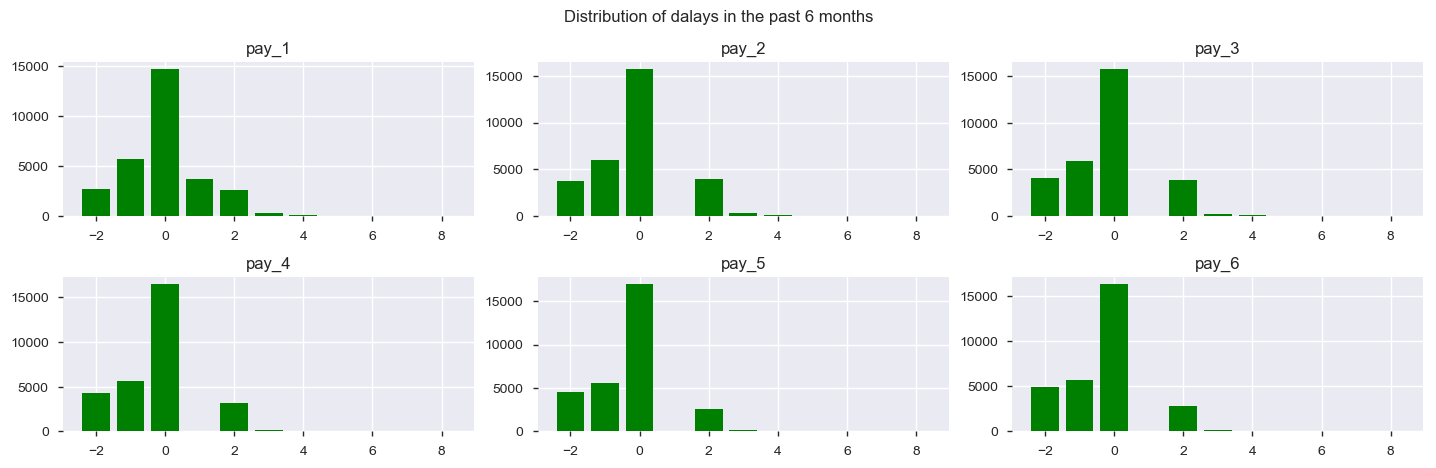

In [21]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of dalays in the past 6 months')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

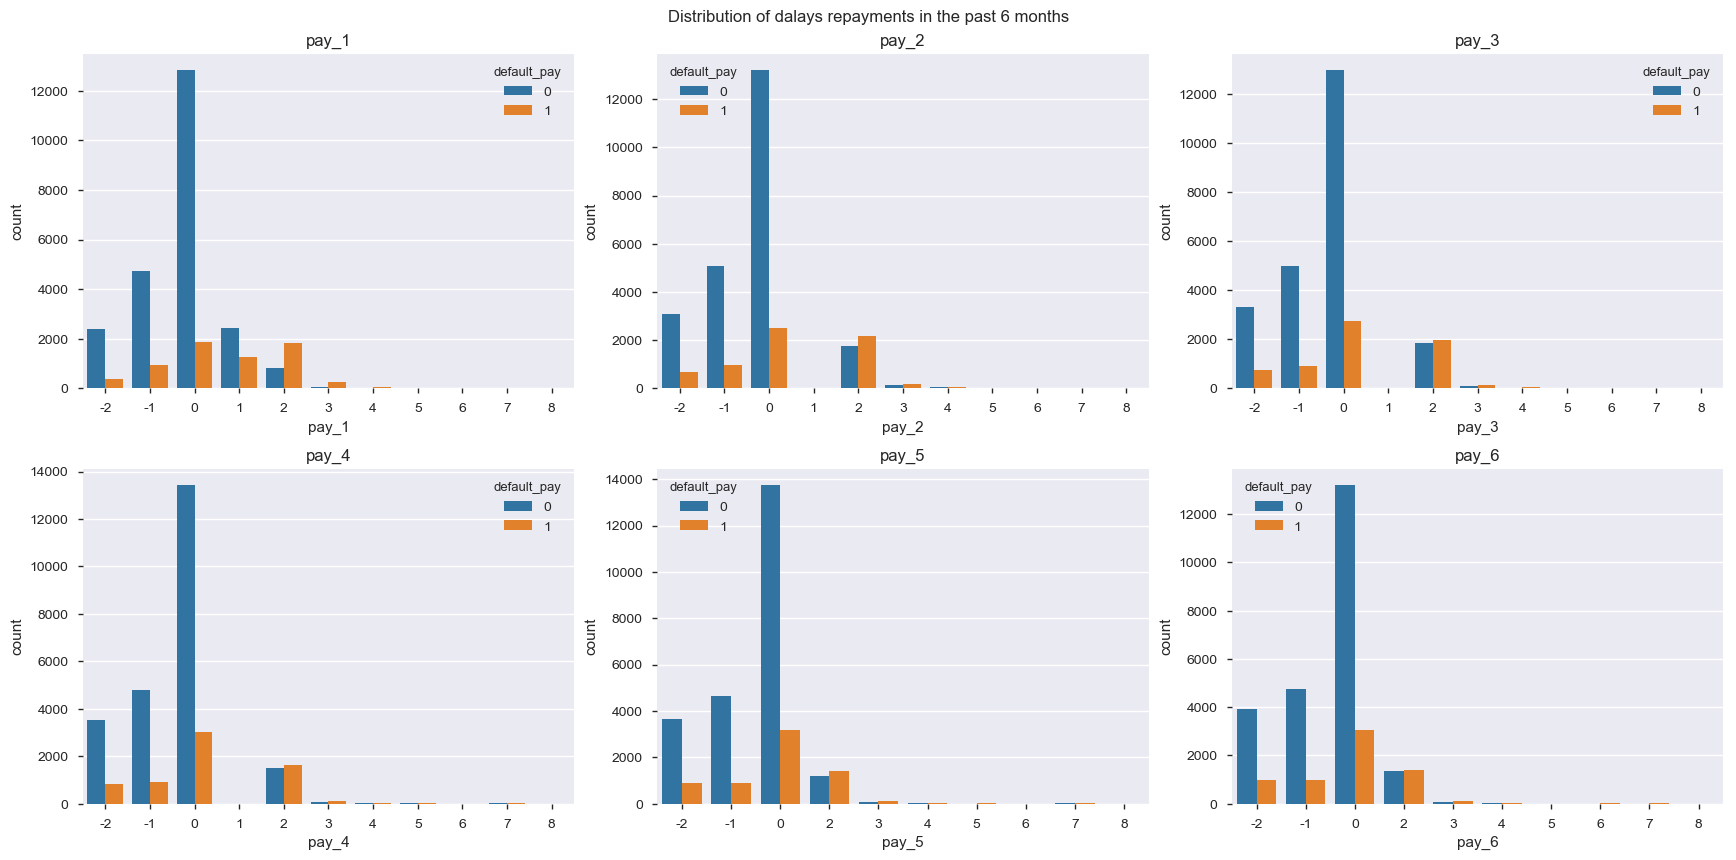

In [22]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(18,9)
fig.suptitle('Distribution of dalays repayments in the past 6 months')
for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3
    sns.countplot(x=pay_status_columns[i], hue="default_pay", data=df, ax=ax[row,col])
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

In [23]:
cols_to_drop = ['pay_1','pay_2','pay_3','pay_4','pay_5','pay_6','sex','education','marriage','default_pay']
df_tmp = df.drop(labels=cols_to_drop,axis=1)
df_tmp.describe()


,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [24]:
lst = list(pay_amt_columns)
lst.extend(bill_amt_columns)
lst.extend(['limit_bal','age','default_pay'])

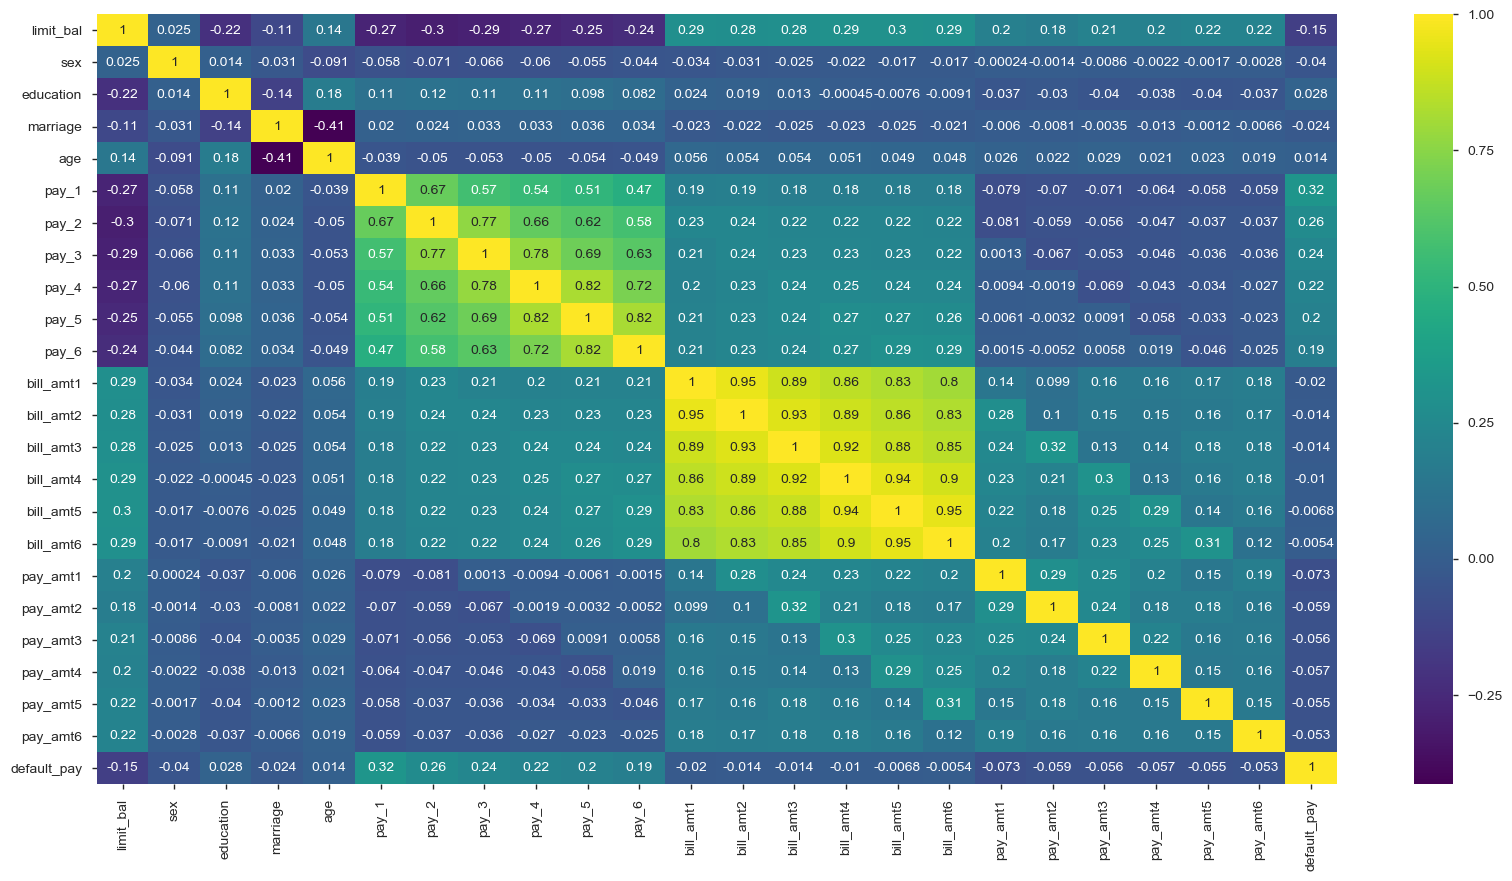

In [25]:
df_corr = df.copy()
df_corr['default_pay'] = df_original['default payment next month']
#correlation matrix
cm = df_corr.corr()
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, cmap = 'viridis')

- __Limit Balance__ is negatively correlated with target variable.
- __bill amt__ features are internally strongly positively correlated

In [26]:
print 'Marriage:  ', pd.unique(df['marriage'])
print 'Education: ', pd.unique(df['education'])
print 'Sex:       ', pd.unique(df['sex'])

Marriage:   [1 2 3 0]
Education:  [2 1 3 5 4 6 0]
Sex:        [2 1]


As per documentation of the dataset, for education, we only have following<br/>
1 = graduate school; 2 = university; 3 = high school; 4 = others<br/>
We will replace 0,5,6 with 'others'

### Exploring Categorical Variables

In [27]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na','married', 'single', 'other'])
df['education'] = df['education'].astype('category').cat.rename_categories(['na','grad_school','university', 'high_school', 'others','unknown1','unknown2'])
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)
for i in pay_status_columns:
    df[i] = df[i].astype('category')

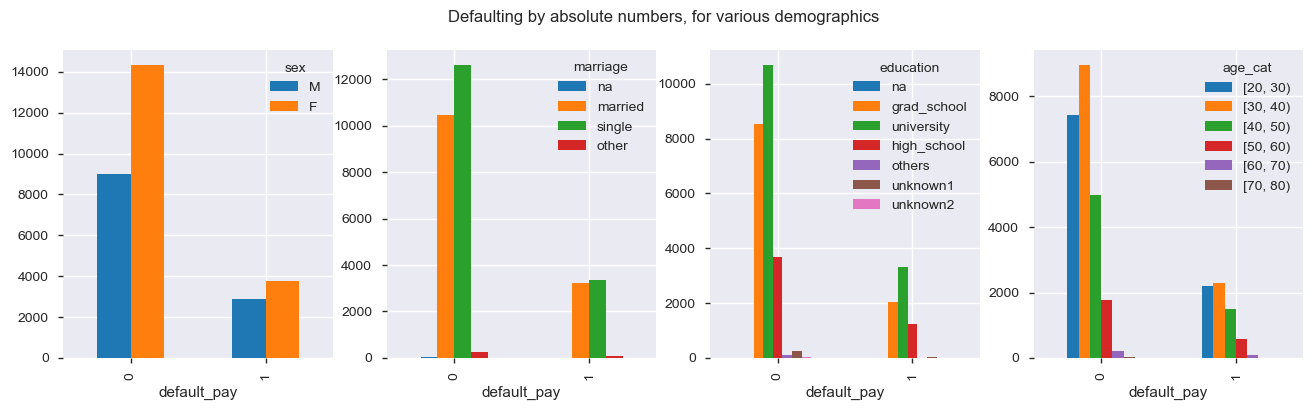

In [28]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(16,4)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['default_pay', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['default_pay', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['default_pay', 'education']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

d = df.groupby(['default_pay', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[3])

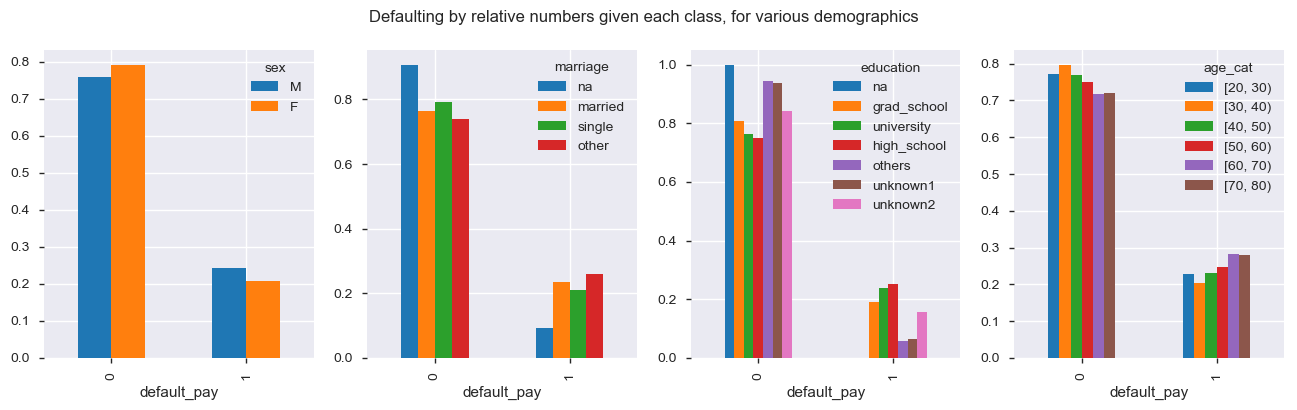

In [29]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(16,4)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = df.groupby(['default_pay', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['default_pay', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['default_pay', 'education']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

d = df.groupby(['default_pay', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[3])

As we can see from the above graph, 
+ Distribution of Gender: 
    - Female credit card holders are more compared to Male
    - Female defaulters are more compared to Male
+ Distribution of Marriage: 
    - Single are holding more credit cards compared to Married and Others
    - Within defaulters Marital status with Others is very minimal. Married and Single have same number of defaulters
+ Distribution of Education:
    - University education has more credit crds. People with education values as Graduate and University have more credit cards.   
+ Distribution by Age:
    - Age 30 to 40 have more credit cards followed by Age 20 to 30.
    - Age 60 to 70 and Age 70 to 80 have very less credit card holders
    - Age 20 to 30 and 30 to 40 have more defaulters

Skewness on limit_bal is :  0.992817316482


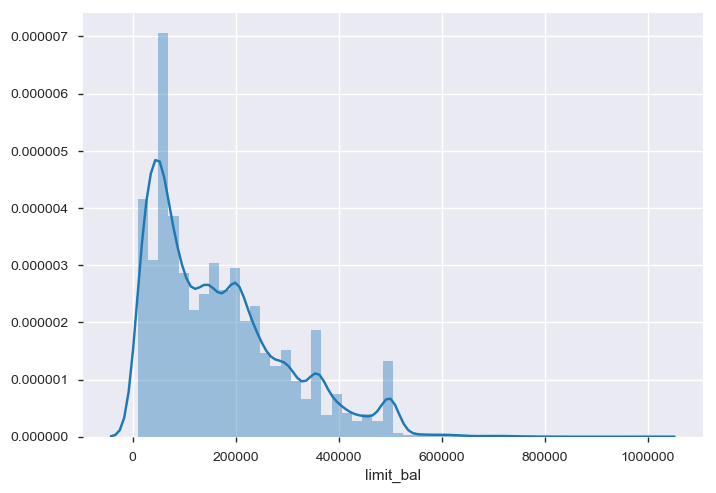

In [30]:
# Credit limit distribution
sns.distplot(df['limit_bal'],kde=True)
print 'Skewness on limit_bal is : ',skew(df['limit_bal'])

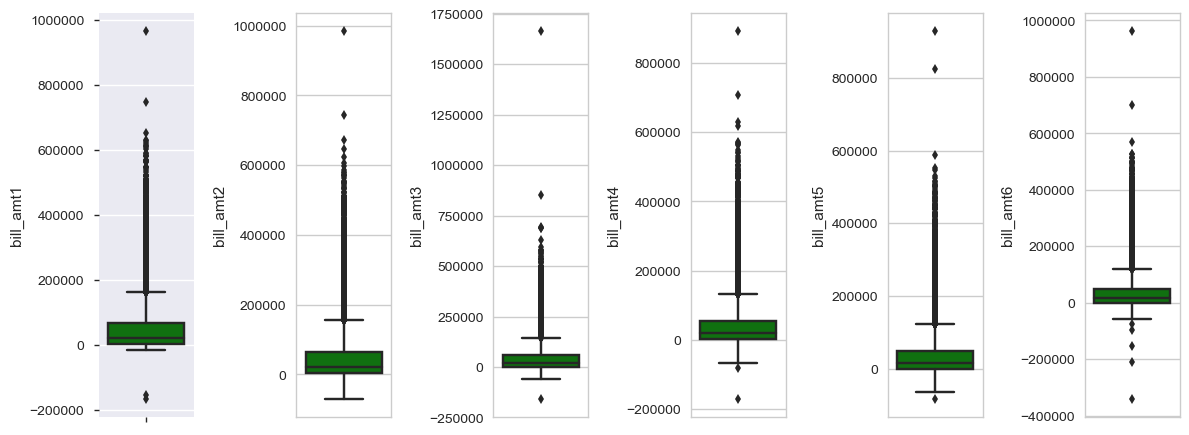

In [31]:
#checking outliers for bill amount[1 to 6]
number_of_columns=6
number_of_rows = len(bill_amt_columns)-1/number_of_columns
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(bill_amt_columns)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[bill_amt_columns[i]],color='green',orient='v')
    plt.tight_layout()

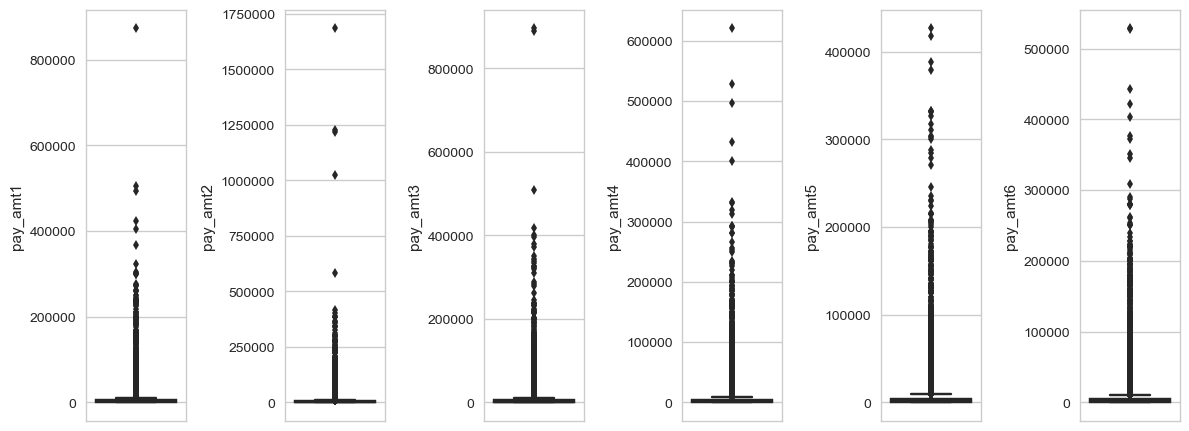

In [32]:
#checking outliers for pay amount[1 to 6]
number_of_columns=6
number_of_rows = len(pay_amt_columns)-1/number_of_columns
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(pay_amt_columns)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[pay_amt_columns[i]],color='green',orient='v')
    plt.tight_layout()

- As it can be observed that data is infested with outliers(by the logic of extreme values beyond 1.5*IQR), but since removing them would cost lot of valuable loss of information.We decided not to treat them as ouliers. 

***

# Feature Engineering

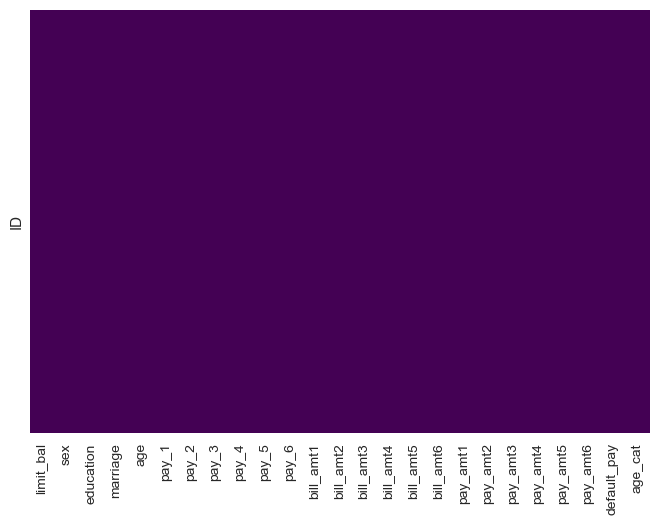

In [33]:
#Checking missing values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#Plane box indicates no missing values

- There are no missing values in data, its a clean dataset.

### Label Encoding

In [34]:
df['grad_school'] = (df['education']==1).astype('int')
df['university'] = (df['education']==2).astype('int')
df['high_school']= (df['education']==3).astype('int')
df['others']= (df['education']==4).astype('int')
df['others']= (df['education']==5).astype('int')
df['others']= (df['education']==6).astype('int')
df['others']= (df['education']==0).astype('int')
df.drop('education',axis=1,inplace=True)

In [35]:
df['male'] = (df['sex']=='M').astype('int')
df.drop('sex',axis=1,inplace=True)


df['married'] = (df['marriage']==1).astype('int')
df['single'] = (df['marriage']==2).astype('int')
df['na'] = (df['marriage']==3).astype('int')
df['na'] = (df['marriage']==0).astype('int')
df.drop(['marriage','age_cat'],axis=1,inplace=True)

# Since 0 is labeled as 'pay duly', every negative value should be seen as 0.
for i in pay_status_columns:
    df[i].replace({-2:-1,-1:-1},inplace=True)
 
df.head()

,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_pay,grad_school,university,high_school,others,male,married,single,na
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-1,-1,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,0,0,0,0,0,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,0,0,0,0,0,0
3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,0,0,0,0,0,0,0
4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0,0,0,0,0,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,0,0,1,0,0,0


## Standardization

In [36]:
#Scaling
scale = ['limit_bal','bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6','pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
robust_scaler = RobustScaler()
df.loc[:,scale] = robust_scaler.fit_transform(df.loc[:,scale])

# df.head()

In [37]:
col_values = df.columns.values
print type(col_values)
out = np.delete(col_values, np.where(col_values == 'default'))
col_values = out 
print col_values

<type 'numpy.ndarray'>
[u'limit_bal' u'age' 'pay_1' u'pay_2' u'pay_3' u'pay_4' u'pay_5' u'pay_6'
 u'bill_amt1' u'bill_amt2' u'bill_amt3' u'bill_amt4' u'bill_amt5'
 u'bill_amt6' u'pay_amt1' u'pay_amt2' u'pay_amt3' u'pay_amt4' u'pay_amt5'
 u'pay_amt6' 'default_pay' 'grad_school' 'university' 'high_school'
 'others' 'male' 'married' 'single' 'na']


# Feature Selection and Model Building

- We tried different methods with aim to find improvements in prediction outcomes.

### _Method 1_  : RFE - wrapper method

In [38]:
lr = LogisticRegression(random_state=9)
dt = DecisionTreeClassifier(random_state=9)
rf = RandomForestClassifier(random_state=9)
X = df.drop('default_pay',axis=1)
y = df['default_pay']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=9,test_size=.2)
# create the RFE model and select 10 attributes
rfe1 = RFE(lr, 10)
rfe1 = rfe1.fit(X, y)
print ('Logistic Regression Feature Rankings:')
print(rfe1.ranking_)
print ('==')*40

rfe2 = RFE(dt, 10)
rfe2 = rfe2.fit(X, y)
print ('Decision Tree Feature Rankings:')
print(rfe2.ranking_)
print ('==')*40

rfe3 = RFE(rf, 10)
rfe3 = rfe3.fit(X, y)
print ('Random Forest Feature Rankings:')
print(rfe2.ranking_)
print ('==')*40

Logistic Regression Feature Rankings:
[ 1 10  1  1  1  3  1  2  1  1  1  6  5 12  1  4 11  7  8  9 16 14 15 13  1
 17 18 19]
Decision Tree Feature Rankings:
[ 2  1  1  7 11 12  8 10  1  1  1  6  1  1  1  3  1  4  5  1 14 15 16 13  9
 17 18 19]
Random Forest Feature Rankings:
[ 2  1  1  7 11 12  8 10  1  1  1  6  1  1  1  3  1  4  5  1 14 15 16 13  9
 17 18 19]


In [39]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF2', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))

from sklearn.model_selection import cross_val_score,KFold
# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)

LR: 0.813333
RF2: 0.806208
DT: 0.721958


Logisitics regression performed better in kfold 

In [40]:
#Selecting rfe1 features since lr performed good in KFold
X = df.iloc[:,[0,2,3,4,6,10,8,9,14,24]]
y = df.default_pay
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=9,test_size=.2)

lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=9, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
y_pred = lr.predict(X_test)
model = lr
model_name = 'ITR1: Logistic Regression (post RFE)'
model_description = 'ITR1: Logistic Regression (with RFE)'
df_metric = save_performance_metrics(model, model_name, model_description, X_test, y_test, X_train, y_train)
# display(CMatrix(CM))
# display(df_metric)
# plot_roc_and_precision(model_name, model, X_test, y_test)

In [42]:
print(classification_report(y_true=y_test,y_pred=y_pred))
print 'mcc : {}'.format( matthews_corrcoef(y_true=y_test,y_pred=y_pred))
tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=y_pred).ravel()
print("\n TN: {} FP: {} FN: {} TP: {} \n".format(tn, fp, fn, tp))
print 'auc: {}'.format(roc_auc_score(y_true=y_test,y_score=y_pred))
print 'accuracy: {}'.format(accuracy_score(y_true=y_test,y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.83      0.96      0.89      4678
          1       0.70      0.28      0.40      1322

avg / total       0.80      0.81      0.78      6000

mcc : 0.359552629777

 TN: 4514 FP: 164 FN: 948 TP: 374 

auc: 0.623923486445
accuracy: 0.814666666667


In [43]:
#RFE with RandomForest since there was just .01 difference between lr
# create the RFE model and select 10 attributes
X = df.iloc[:,[0,1,2,8,9,10,11,12,13,15]]
y = df.default_pay
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=9,test_size=.2)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print 'mcc : {}'.format( matthews_corrcoef(y_true=y_test,y_pred=y_pred))
tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=y_pred).ravel()
print("\n TN: {} FP: {} FN: {} TP: {} \n".format(tn, fp, fn, tp))
print 'auc: {}'.format(roc_auc_score(y_true=y_test,y_score=y_pred))
print 'accuracy: {}'.format(accuracy_score(y_true=y_test,y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.83      0.94      0.88      4678
          1       0.58      0.32      0.41      1322

avg / total       0.78      0.80      0.78      6000

mcc : 0.325561825833

 TN: 4376 FP: 302 FN: 898 TP: 424 

auc: 0.62808433463
accuracy: 0.8


In [44]:
#Stcaking Ensemble with RFE1
X = df.iloc[:,[0,2,3,4,6,10,8,9,14,24]]
y = df['default_pay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=9)
X_train1, X_test1, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=9)

M1 = LogisticRegression()
M2 = DecisionTreeClassifier(max_depth=1,criterion='entropy')
M3 = DecisionTreeClassifier(max_depth=2,criterion='entropy')
M4 = DecisionTreeClassifier(max_depth=1,criterion='entropy')
M5 = DecisionTreeClassifier(max_depth=1,criterion='entropy')



M1.fit(X_train1,y_train2)
M2.fit(X_train1,y_train2)
M3.fit(X_train1,y_train2)
M4.fit(X_train1,y_train2)
M5.fit(X_train1,y_train2)


pred1 = M1.predict_proba(X_test1)
pred2 = M2.predict_proba(X_test1)
pred3 = M3.predict_proba(X_test1)
pred4 = M4.predict_proba(X_test1)
pred5 = M5.predict_proba(X_test1)


A = pd.DataFrame(pred1)[1]
B = pd.DataFrame(pred2)[1]
C = pd.DataFrame(pred3)[1]
D = pd.DataFrame(pred4)[1]
E = pd.DataFrame(pred5)[1]

X_meta = pd.concat([A,B,C,D,E],axis=1)

meta_classifier = RandomForestClassifier(max_depth=2,n_estimators=100)
meta_classifier.fit(X_meta,y_test2)


pred6 = M1.predict_proba(X_test)
pred7 = M2.predict_proba(X_test)
pred8 = M3.predict_proba(X_test)
pred9 = M4.predict_proba(X_test)
pred10 = M5.predict_proba(X_test)


F = pd.DataFrame(pred6)[1]
G = pd.DataFrame(pred7)[1]
H = pd.DataFrame(pred8)[1]
I = pd.DataFrame(pred9)[1]
J = pd.DataFrame(pred10)[1]

K = pd.concat([F,G,H,I,J], axis=1)
y_meta = meta_classifier.predict(K)

In [45]:
print classification_report(y_meta,y_test)
print "auc:{}".format(roc_auc_score(y_meta,y_test)) 
print "mcc: {}".format(matthews_corrcoef(y_meta,y_test))
tn, fp, fn, tp = confusion_matrix(y_meta,y_test).ravel()
print ("\n TN: {} FP: {} FN: {} TP: {} \n".format(tn, fp, fn, tp))
print "accuracy: {}".format(accuracy_score(y_meta,y_test))

             precision    recall  f1-score   support

          0       0.95      0.84      0.89      2692
          1       0.32      0.65      0.42       308

avg / total       0.89      0.82      0.84      3000

auc:0.745132282279
mcc: 0.363657965217

 TN: 2255 FP: 437 FN: 107 TP: 201 

accuracy: 0.818666666667


In [46]:
#Stcaking Ensemble with RFE3
X = df.iloc[:,[0,2,1,10,8,9,11,12,13,15]]
y = df['default_pay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=9)
X_train1, X_test1, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=9)

M1 = LogisticRegression()
M2 = DecisionTreeClassifier(max_depth=1,criterion='entropy')
M3 = DecisionTreeClassifier(max_depth=2,criterion='entropy')
M4 = DecisionTreeClassifier(max_depth=1,criterion='entropy')
M5 = DecisionTreeClassifier(max_depth=1,criterion='entropy')



M1.fit(X_train1,y_train2)
M2.fit(X_train1,y_train2)
M3.fit(X_train1,y_train2)
M4.fit(X_train1,y_train2)
M5.fit(X_train1,y_train2)


pred1 = M1.predict_proba(X_test1)
pred2 = M2.predict_proba(X_test1)
pred3 = M3.predict_proba(X_test1)
pred4 = M4.predict_proba(X_test1)
pred5 = M5.predict_proba(X_test1)


A = pd.DataFrame(pred1)[1]
B = pd.DataFrame(pred2)[1]
C = pd.DataFrame(pred3)[1]
D = pd.DataFrame(pred4)[1]
E = pd.DataFrame(pred5)[1]

X_meta = pd.concat([A,B,C,D,E],axis=1)

meta_classifier = RandomForestClassifier(max_depth=2,n_estimators=100)
meta_classifier.fit(X_meta,y_test2)


pred6 = M1.predict_proba(X_test)
pred7 = M2.predict_proba(X_test)
pred8 = M3.predict_proba(X_test)
pred9 = M4.predict_proba(X_test)
pred10 = M5.predict_proba(X_test)


F = pd.DataFrame(pred6)[1]
G = pd.DataFrame(pred7)[1]
H = pd.DataFrame(pred8)[1]
I = pd.DataFrame(pred9)[1]
J = pd.DataFrame(pred10)[1]

K = pd.concat([F,G,H,I,J], axis=1)
y_meta = meta_classifier.predict(K)

In [47]:
print classification_report(y_meta,y_test)
print "auc:{}".format(roc_auc_score(y_meta,y_test)) 
print "mcc: {}".format(matthews_corrcoef(y_meta,y_test))
tn, fp, fn, tp = confusion_matrix(y_meta,y_test).ravel()
print ("\n TN: {} FP: {} FN: {} TP: {} \n".format(tn, fp, fn, tp))
print "accuracy: {}".format(accuracy_score(y_meta,y_test))

             precision    recall  f1-score   support

          0       0.95      0.84      0.89      2692
          1       0.32      0.65      0.42       308

avg / total       0.89      0.82      0.84      3000

auc:0.745132282279
mcc: 0.363657965217

 TN: 2255 FP: 437 FN: 107 TP: 201 

accuracy: 0.818666666667


## _Method 2: PCA_

In [48]:
from sklearn.preprocessing import scale
from sklearn.feature_selection import chi2,f_classif,SelectKBest
from sklearn.decomposition import PCA
#converting dataframe into numpy Array
X = df.drop('default_pay',axis=1)
Y = df.default_pay

# Split-out validation dataset
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

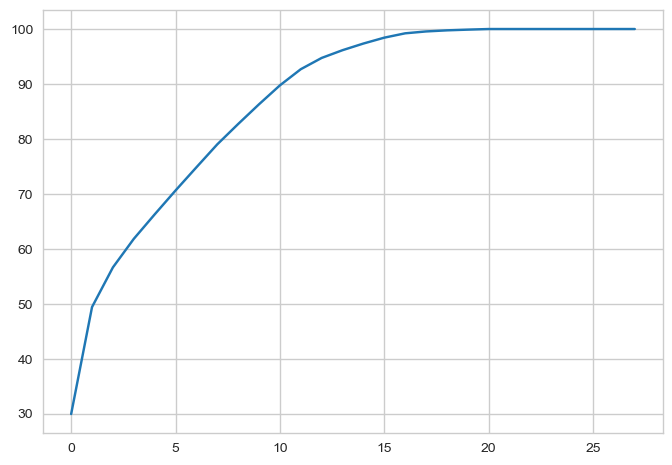

In [49]:
#Scaling the values
X_t = scale(X_train)

#initially lets create 28 components which is actual number of Variables we have
pca = PCA(n_components=28)

pca.fit(X_t)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#lets see Cumulative Variance plot
plt.plot(var1)

In [50]:
#Looking at above plot I'm taking 16 variables
pca = PCA(n_components=16)
pca.fit(X_t)
X_train_PC=pca.fit_transform(X_t)
# X_train_PC

In [51]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('RF2', RandomForestClassifier(random_state=9)))
models.append(('DT', DecisionTreeClassifier(random_state=9)))

from sklearn.model_selection import cross_val_score,KFold
# evaluate each model in turn
results = []
names = []
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train_PC, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)

LR: 0.814000
RF2: 0.802458
DT: 0.726458


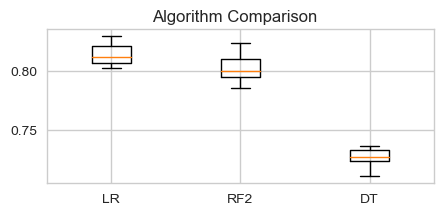

In [64]:
# Comparing Algorithms
fig = plt.figure(figsize=(5,2))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#Scaling the X_validation data
X_v = scale(X_validation)

pca.fit(X_v)
X_validation_PC=pca.fit_transform(X_v)

In [61]:
# Make predictions on validation dataset by choosing best Algorithm
lr = LogisticRegression(random_state=9)
lr.fit(X_train_PC, Y_train)
predictions = lr.predict(X_validation_PC)
print "accuracy: {}".format(accuracy_score(Y_validation, predictions))
tn, fp, fn, tp = confusion_matrix(Y_validation, predictions).ravel()
print ("\n TN: {} FP: {} FN: {} TP: {} \n".format(tn, fp, fn, tp))
print(classification_report(Y_validation, predictions))
print "mcc: {}".format(matthews_corrcoef(Y_validation, predictions))
print 'auc: {}'.format(roc_auc_score(Y_validation, predictions))

accuracy: 0.7585

 TN: 4504 FP: 206 FN: 1243 TP: 47 

             precision    recall  f1-score   support

          0       0.78      0.96      0.86      4710
          1       0.19      0.04      0.06      1290

avg / total       0.66      0.76      0.69      6000

mcc: -0.0149280561809
auc: 0.496348689083


### _Method  3 : Select From Model_

In [54]:
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

X = df.drop('default_pay',axis=1)
y = df.default_pay
print('Before');
print(X.shape)

clf = RandomForestClassifier()
clf.fit(X, y)

print('\nFeature Importance');
print(clf.feature_importances_)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

print('\nAfter'); 
print(X_new.shape)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.20, random_state=42)
smote = SMOTE(random_state=9, kind="borderline2")               # With OverSampling Technique considering data is imbalance for a moment 
X_sample, y_sample = smote.fit_sample(X_train, y_train)
clf.fit(X_sample, y_sample)
y_pred = clf.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print 'mcc : {}'.format( matthews_corrcoef(y_true=y_test,y_pred=y_pred))
tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=y_pred).ravel()
print("\n TN: {} FP: {} FN: {} TP: {} \n".format(tn, fp, fn, tp))
print 'auc: {}'.format(roc_auc_score(y_true=y_test,y_score=y_pred))
print 'accuracy: {}'.format(accuracy_score(y_true=y_test,y_pred=y_pred))

Before
(30000, 28)

Feature Importance
[ 0.06194828  0.07333613  0.11702646  0.02131322  0.03576965  0.01150955
  0.02655614  0.01116716  0.0663911   0.05492814  0.05374114  0.05377595
  0.05087561  0.05305673  0.05371514  0.05156207  0.04817873  0.0466873
  0.04406947  0.05253333  0.          0.          0.          0.
  0.01185871  0.          0.          0.        ]

After
(30000L, 16L)
             precision    recall  f1-score   support

          0       0.84      0.87      0.86      4687
          1       0.48      0.43      0.45      1313

avg / total       0.77      0.77      0.77      6000

mcc : 0.312315669778

 TN: 4080 FP: 607 FN: 750 TP: 563 

auc: 0.64964094266
accuracy: 0.773833333333


***

### _Method 4: SelectKBest_

Predicted,pay,default,Total
Actual,,,
pay,4534,153,4687
default,968,345,1313
Total,5502,498,6000


,Model,Model_Desc,TP,FP,FN,TN,AUC,Accuracy_Score,Precision,Recall,F1_Score,Matt_Coeff
0,"ITR2(KBest,K=25): Simple Logistic Regression","ITR2(KBest,K=25): basic Logistic Regression ap...",345,153,968,4534,0.615057,0.813167,0.692771,0.262757,0.381005,0.344863


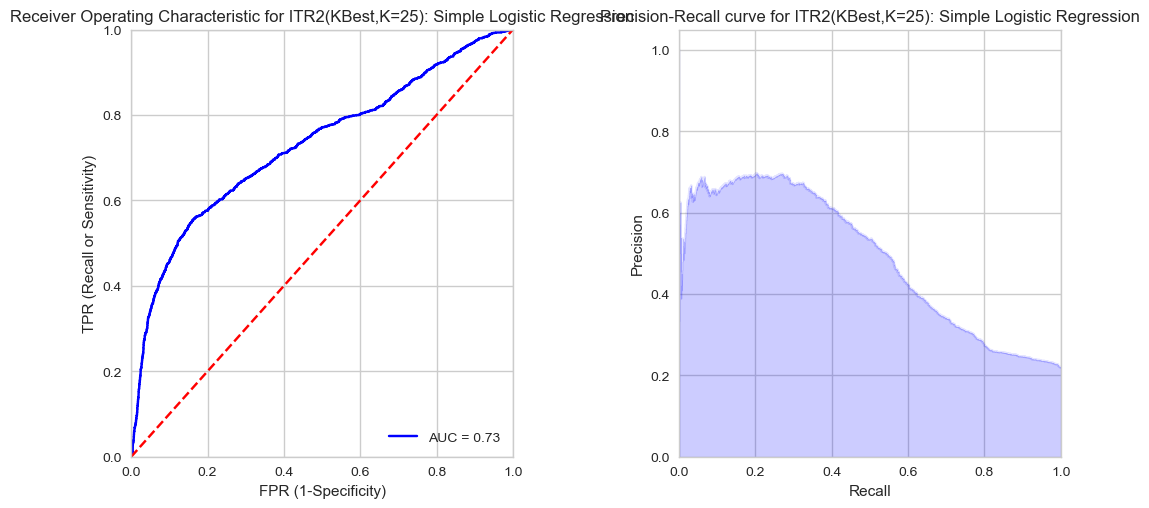

In [58]:
LogR = LogisticRegression(random_state=10)
LogR.fit(X_train, y_train)
y_pred_test = LogR.predict(X_test)
metrics.loc['accuracy','LogR'] = accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','LogR'] = precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','LogR'] = recall_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['auc_roc_score','LogR'] = roc_auc_score(y_score=y_pred_test,y_true=y_test)
CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
model = LogR
model_name = 'ITR2(KBest,K=25): Simple Logistic Regression'
model_description = 'ITR2(KBest,K=25): basic Logistic Regression applied'
df_metric = save_performance_metrics(model, model_name, model_description, X_test, y_test, X_train, y_train)
display(CMatrix(CM))
display(df_metric)
plot_roc_and_precision(model_name, model, X_test, y_test)
# display(df_all_models)

Predicted,pay,default,Total
Actual,,,
pay,4516,171,4687
default,912,401,1313
Total,5428,572,6000


,Model,Model_Desc,TP,FP,FN,TN,AUC,Accuracy_Score,Precision,Recall,F1_Score,Matt_Coeff
0,"ITR2(KBest,K=25): Decision Tree","ITR2(KBest,K=25): Decision Tree (with max_leaf...",401,171,912,4516,0.634462,0.8195,0.701049,0.305407,0.425464,0.378609


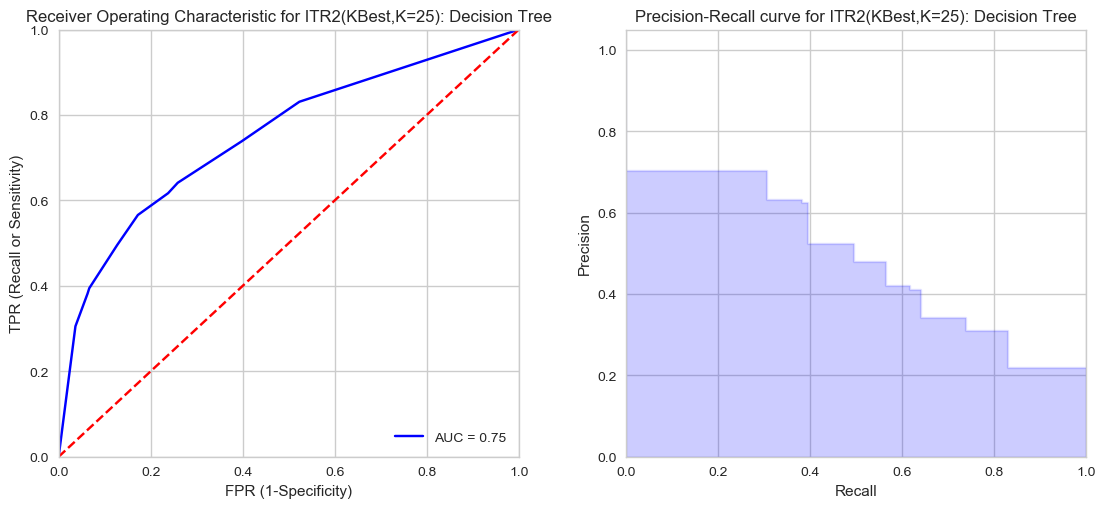

In [59]:
DTree = DecisionTreeClassifier(max_leaf_nodes=10,min_samples_split=30)
DTree.fit(X_train, y_train)
# print len(X_train[0])
y_pred_test = DTree.predict(X_test)
metrics.loc['accuracy','DTree'] = accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','DTree'] = precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','DTree'] = recall_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['auc_roc_score','DTree'] = roc_auc_score(y_score=y_pred_test,y_true=y_test)
CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
model = DTree
model_name = 'ITR2(KBest,K=25): Decision Tree'
model_description = 'ITR2(KBest,K=25): Decision Tree (with max_leaf_node=10, sample_split=30)'
df_metric = save_performance_metrics(model, model_name, model_description, X_test, y_test, X_train, y_train)
display(CMatrix(CM))
display(df_metric)
plot_roc_and_precision(model_name, model, X_test, y_test)

***

### _Method 5: XgBoost_

In [55]:
from xgboost import XGBClassifier

In [56]:
#converting dataframe into numpy Array
X = df.drop('default_pay',axis=1)
Y = df.default_pay

# Split-out validation dataset
validation_size = 0.20
seed = 7
X_trainB, X_testB, Y_trainB, Y_testB = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [57]:
# fit model on training data
XGBoost = XGBClassifier()
XGBoost.fit(X_trainB, Y_trainB)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [58]:
# make predictions for test data
y_predB = XGBoost.predict(X_testB)
predictions = [round(value) for value in y_predB]

In [61]:
# evaluate predictions
print(classification_report(y_true=Y_testB,y_pred=y_predB))
print 'mcc : {}'.format( matthews_corrcoef(y_true=Y_testB,y_pred=y_predB))
tn, fp, fn, tp = confusion_matrix(y_true=Y_testB,y_pred=y_predB).ravel()
print("\n TN: {} FP: {} FN: {} TP: {} \n".format(tn, fp, fn, tp))
print 'auc: {}'.format(roc_auc_score(y_true=Y_testB,y_score=y_predB))
print 'accuracy: {}'.format(accuracy_score(y_true=Y_testB,y_pred=y_predB))

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      4710
          1       0.65      0.35      0.46      1290

avg / total       0.80      0.82      0.80      6000

mcc : 0.383812529886

 TN: 4466 FP: 244 FN: 837 TP: 453 

auc: 0.649679059892
accuracy: 0.819833333333


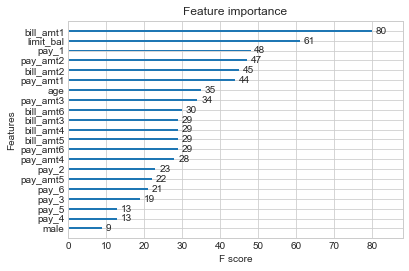

In [62]:
# plot feature importance using built-in function
from xgboost import plot_importance
plot_importance(XGBoost)
plt.show()

***

## Other approach - Month-wise models

In [ ]:
df1 = df.copy()
pd.unique(df_sample['pay_1'])

In [ ]:
for i in pay_status_columns:
    df_sample[i].replace({-2:0,-1:0,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1},inplace=True)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y,random_state = 9,train_size = 0.80)

In [ ]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=4)
clf_gini.fit(X_train,y_train)

y_pred = clf_gini.predict(X_test)
y_pred

In [ ]:
auc = metrics.roc_auc_score(y_test, y_pred)
auc

In [ ]:
z = confusion_matrix(y_test, y_pred)
y = classification_report(y_test, y_pred)
train_score, test_score = clf_gini.score(X_train,y_train), clf_gini.score(X_test, y_test)
print train_score, test_score
print y, z
#print roc_auc_score(y_true=y_10,y_score=y_pred_final)

In [ ]:
df_sample_90, df_sample_10 = train_test_split(df,random_state = 9,train_size = 0.90)
y_train, y_test = train_test_split(df_sample_90['default_pay'],random_state = 9,train_size = 0.80)
y_10 = df_sample_10['default_pay']

In [ ]:
df_90 = df_sample_90
df_10 = df_sample_10
y_test.shape

In [ ]:
X1=df_90[['limit_bal','education','age','sex','bill_amt1','pay_amt1']]
y1=df_90['pay_1']
X2=df_90[['limit_bal','education','age','sex','bill_amt2','pay_amt2']]
y2=df_90['pay_2']
X3=df_90[['limit_bal','education','age','sex','bill_amt3','pay_amt3']]
y3=df_90['pay_3']
X4=df_90[['limit_bal','education','age','sex','bill_amt4','pay_amt4']]
y4=df_90['pay_4']
X5=df_90[['limit_bal','education','age','sex','bill_amt5','pay_amt5']]
y5=df_90['pay_5']
X6=df_90[['limit_bal','education','age','sex','bill_amt6','pay_amt6']]
y6=df_90['pay_6']
X1.info()

In [ ]:
rfe = RFE(X2_dt)
rfe = rfe.fit(X2, y2)
print(rfe.ranking_)

In [ ]:
X1=df_90[['limit_bal','bill_amt1','pay_amt1']]
y1=df_90['pay_1']
X2=df_90[['limit_bal','bill_amt2','pay_amt2']]
y2=df_90['pay_2']
X3=df_90[['limit_bal','bill_amt3','pay_amt3']]
y3=df_90['pay_3']
X4=df_90[['limit_bal','bill_amt4','pay_amt4']]
y4=df_90['pay_4']
X5=df_90[['limit_bal','bill_amt5','pay_amt5']]
y5=df_90['pay_5']
X6=df_90[['limit_bal','bill_amt6','pay_amt6']]
y6=df_90['pay_6']

In [ ]:
X1_train,X1_test,X2_train,X2_test,X3_train,X3_test,X4_train,X4_test,X5_train,X5_test,X6_train,X6_test,y1_train,y1_test,y2_train,y2_test,y3_train,y3_test,y4_train,y4_test,y5_train,y5_test,y6_train,y6_test = train_test_split(X1,X2,X3,X4,X5,X6,y1,y2,y3,y4,y5,y6,random_state = 9,train_size = 0.80)

In [ ]:
from sklearn.model_selection import cross_val_score,KFold
X1_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
kfold = KFold(n_splits=5)
cv_results = cross_val_score(X1_dt, X1_train, y1_train, cv=kfold, scoring='accuracy')
print cv_results.mean()

In [ ]:
X1_dt.fit(X1_train,y1_train)

y_pred1 = X1_dt.predict(X1_test)
y_pred1
a = confusion_matrix(y1_test, y_pred1)
b = classification_report(y1_test, y_pred1)
train_score, test_score = X1_dt.score(X1_train, y1_train), X1_dt.score(X1_test, y1_test)
print b, train_score, test_score
print y_pred1

In [ ]:
kfold = KFold(n_splits=5)
X1_lr = LogisticRegression()

cv_results = cross_val_score(X1_lr, X1_train, y1_train, cv=kfold, scoring='accuracy')
print cv_results.mean()

In [ ]:
X1_lr.fit(X1_train,y1_train)

y_pred1 = X1_lr.predict(X1_test)
y_pred1
a = confusion_matrix(y1_test, y_pred1)
b = classification_report(y1_test, y_pred1)
train_score, test_score = X1_dt.score(X1_train, y1_train), X1_dt.score(X1_test, y1_test)
print b, train_score, test_score
print y_pred1

In [ ]:
kfold = KFold(n_splits=5)
X1_rf = RandomForestClassifier()

cv_results = cross_val_score(X1_rf, X1_train, y1_train, cv=kfold, scoring='accuracy')
print cv_results.mean()

In [ ]:
X1_rf.fit(X1_train,y1_train)

y_pred1 = X1_rf.predict(X1_test)
y_pred1
a = confusion_matrix(y1_test, y_pred1)
b = classification_report(y1_test, y_pred1)
train_score, test_score = X1_dt.score(X1_train, y1_train), X1_dt.score(X1_test, y1_test)
print b, train_score, test_score
print y_pred1

In [ ]:
from sklearn.model_selection import cross_val_score,KFold
X2_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
kfold = KFold(n_splits=5)
cv_results = cross_val_score(X2_dt, X2_train, y2_train, cv=kfold, scoring='accuracy')
print cv_results.mean()

In [ ]:
X2_dt.fit(X2_train,y2_train)

y_pred2 = X2_dt.predict(X2_test)
y_pred2
c = confusion_matrix(y2_test, y_pred1)
d = classification_report(y2_test, y_pred2)
train_score, test_score = X2_dt.score(X2_train, y2_train), X2_dt.score(X2_test, y2_test)
print d, train_score, test_score

In [ ]:
X3_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
kfold = KFold(n_splits=5)
cv_results = cross_val_score(X3_dt, X3_train, y3_train, cv=kfold, scoring='accuracy')
print cv_results.mean()

In [ ]:
X3_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
X3_dt.fit(X3_train,y3_train)

y_pred3 = X3_dt.predict(X3_test)
y_pred3
e = confusion_matrix(y3_test, y_pred3)
f = classification_report(y3_test, y_pred3)
train_score, test_score = X3_dt.score(X3_train, y3_train), X3_dt.score(X3_test, y3_test)
print f, train_score, test_score

In [ ]:
X4_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
kfold = KFold(n_splits=5)
cv_results = cross_val_score(X4_dt, X4_train, y4_train, cv=kfold, scoring='accuracy')
print cv_results.mean()

In [ ]:
#X4_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
X4_dt.fit(X4_train,y4_train)

y_pred4 = X4_dt.predict(X4_test)
y_pred4
g = confusion_matrix(y4_test, y_pred4)
h = classification_report(y4_test, y_pred4)
train_score, test_score = X4_dt.score(X4_train, y4_train), X4_dt.score(X4_test, y4_test)
print h, train_score, test_score

In [ ]:
X5_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
kfold = KFold(n_splits=5)
cv_results = cross_val_score(X5_dt, X5_train, y5_train, cv=kfold, scoring='accuracy')
print cv_results.mean()

In [ ]:
#X5_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
X5_dt.fit(X5_train,y5_train)

y_pred5 = X5_dt.predict(X5_test)
y_pred5
i = confusion_matrix(y5_test, y_pred5)
j = classification_report(y5_test, y_pred5)
train_score, test_score = X5_dt.score(X5_train, y5_train), X5_dt.score(X5_test, y5_test)
print j, train_score, test_score

In [ ]:
X6_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
kfold = KFold(n_splits=5)
cv_results = cross_val_score(X6_dt, X6_train, y6_train, cv=kfold, scoring='accuracy')
print cv_results.mean()

In [ ]:
#X6_dt = DecisionTreeClassifier(criterion='gini',max_depth=4)
X6_dt.fit(X6_train,y6_train)

y_pred6 = X6_dt.predict(X6_test)
y_pred6
k = confusion_matrix(y6_test, y_pred6)
l = classification_report(y6_test, y_pred6)
train_score, test_score = X6_dt.score(X6_train, y6_train), X6_dt.score(X6_test, y6_test)
print l, train_score, test_score

In [ ]:
y_pred = pd.DataFrame(list(zip(y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6)),columns=['p1','p2','p3','p4','p5','p6'])
y_pred.head()
y_test.reshape(-1,1)
lr = LogisticRegression()
lr.fit(y_pred,y_test.reshape(-1,1))

In [ ]:
X1_10=df_10[['limit_bal','bill_amt1','pay_amt1']]
y1_10=df_10['pay_1']
X2_10=df_10[['limit_bal','bill_amt2','pay_amt2']]
y2_10=df_10['pay_2']
X3_10=df_10[['limit_bal','bill_amt3','pay_amt3']]
y3_10=df_10['pay_3']
X4_10=df_10[['limit_bal','bill_amt4','pay_amt4']]
y4_10=df_10['pay_4']
X5_10=df_10[['limit_bal','bill_amt5','pay_amt5']]
y5_10=df_10['pay_5']
X6_10=df_10[['limit_bal','bill_amt6','pay_amt6']]
y6_10=df_10['pay_6']

In [ ]:
y_10_pred1 = X1_dt.predict(X1_10)
y_10_pred1

In [ ]:
y_10_pred2 = X2_dt.predict(X2_10)
y_10_pred2

In [ ]:
y_10_pred3 = X3_dt.predict(X3_10)
y_10_pred3

In [ ]:
y_10_pred4 = X4_dt.predict(X4_10)
y_10_pred4

In [ ]:
y_10_pred5 = X5_dt.predict(X5_10)
y_10_pred5

In [ ]:
y_10_pred6 = X6_dt.predict(X6_10)
y_10_pred6

In [ ]:
y_pred_10 = pd.DataFrame(list(zip(y_10_pred1,y_10_pred2,y_10_pred3,y_10_pred4,y_10_pred5,y_10_pred6)),columns=['p10_1','p10_2','p10_3','p10_4','p10_5','p10_6'])
y_pred_10.head()

In [ ]:
y_pred_final.reshape(-1,1).shape

In [ ]:
y_pred_final = lr.predict(y_pred_10)
y_pred_final

In [ ]:
y_10.reshape(-1,1)

In [ ]:
m = confusion_matrix(y_10, y_pred_final)
n = classification_report(y_10, y_pred_final)
train_score, test_score = lr.score(y_pred,y_test), lr.score(y_pred_10, y_10)
print train_score, test_score
print n
print roc_auc_score(y_true=y_10,y_score=y_pred_final)

***